Louie Balderrama<br>
Springboard Data Science Career Track, January 2019 cohort<br>

<h1 align="center">Capstone Project II</h1>

# Introduction #
**Problem Statement**: Classifying Amazon reviews based on customer ratings using NLP

<h4 align="center">Impact</h4>

Reviews provide objective feedback to a product and are therefore inherently useful for consumers. These ratings are often summarized by a numerical rating, or the number of stars. Of course there is more value in the actual text itself than the quantified stars. And at times, the given rating does not truly convey the experience of the product – the heart of the feedback is actually in the text itself. The goal therefore is to build a classifier that would understand the essence of a piece of review and assign it the most appropriate rating based on the meaning of the text.

<h4 align="center">Background</h4>

Though product ratings on Amazon are aggregated from all the reviews by every customer, each individual rating is actually only an integer that ranges from one star to five stars. This reduces our predictions to discrete classes totaling five possibilities. Therefore what we'll have is a supervised, multi-class classifier with the actual review text as the core predictor.

This study is an exploration of Natural Language Processing (NLP). The goal of predicting the star rating given a piece of text will take on different NLP topics including word embedding, topic modeling, and dimension reduction. From there, we'll arrive on a final dataframe and we'll be employing different machine learning techniques in order to come up with the best approach (i.e. most accurate estimator) for our classifier.

<h4 align="center" id="Datasets">Datasets</h4>

The [Amazon dataset](http://jmcauley.ucsd.edu/data/amazon/index.html) contains the customer reviews for all listed *Electronics* products spanning from May 1996 up to July 2014. There are a total of 1,689,188 reviews by a total of 192,403 customers on 63,001 unique products. The data dictionary is as follows:

*  **asin** - Unique ID of the product being reviewed, *string*
*  **helpful** - A list with two elements: the number of users that voted *helpful*, and the total number of users that voted on the review (including the *not helpful* votes), *list*
*  **overall** - The reviewer's rating of the product, *int64*
*  **reviewText** - The review text itself, *string*
*  **reviewerID** - Unique ID of the reviewer, *string*
*  **reviewerName** - Specified name of the reviewer, *string*
*  **summary** - Headline summary of the review, *string*
*  **unixReviewTime** - Unix Time of when the review was posted, *string*

# Data Wrangling #

In [1]:
import warnings

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", DeprecationWarning)

The `df` is created from the Amazon dataset. If the file has been downloaded then the dataset is loaded from the local file. Otherwise the file is accessed and extracted directly from the repository.

In [2]:
import os
import pandas as pd

dataset = "Electronics_5.json"

if os.path.isfile(dataset):
    df = pd.read_json("Electronics_5.json", lines=True)
else:
    url = r"http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz"
    df = pd.read_json(url, compression='gzip', lines=True)

display(df.head(10))

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0528881469,"[0, 0]",5,We got this GPS for my husband who is an (OTR)...,"06 2, 2013",AO94DHGC771SJ,amazdnu,Gotta have GPS!,1370131200
1,0528881469,"[12, 15]",1,"I'm a professional OTR truck driver, and I bou...","11 25, 2010",AMO214LNFCEI4,Amazon Customer,Very Disappointed,1290643200
2,0528881469,"[43, 45]",3,"Well, what can I say. I've had this unit in m...","09 9, 2010",A3N7T0DY83Y4IG,C. A. Freeman,1st impression,1283990400
3,0528881469,"[9, 10]",2,"Not going to write a long review, even thought...","11 24, 2010",A1H8PY3QHMQQA0,"Dave M. Shaw ""mack dave""","Great grafics, POOR GPS",1290556800
4,0528881469,"[0, 0]",1,I've had mine for a year and here's what we go...,"09 29, 2011",A24EV6RXELQZ63,Wayne Smith,"Major issues, only excuses for support",1317254400
5,0594451647,"[3, 3]",5,I am using this with a Nook HD+. It works as d...,"01 3, 2014",A2JXAZZI9PHK9Z,"Billy G. Noland ""Bill Noland""",HDMI Nook adapter cable,1388707200
6,0594451647,"[0, 0]",2,The cable is very wobbly and sometimes disconn...,"04 27, 2014",A2P5U7BDKKT7FW,Christian,Cheap proprietary scam,1398556800
7,0594451647,"[0, 0]",5,This adaptor is real easy to setup and use rig...,"05 4, 2014",AAZ084UMH8VZ2,"D. L. Brown ""A Knower Of Good Things""",A Perfdect Nook HD+ hook up,1399161600
8,0594451647,"[0, 0]",4,This adapter easily connects my Nook HD 7&#34;...,"07 11, 2014",AEZ3CR6BKIROJ,Mark Dietter,A nice easy to use accessory.,1405036800
9,0594451647,"[3, 3]",5,This product really works great but I found th...,"01 20, 2014",A3BY5KCNQZXV5U,Matenai,This works great but read the details...,1390176000


Only the `overall` and the `unixReviewTime` series are stored as integers. The rest are interpreted as strings (objects).

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1689188 entries, 0 to 1689187
Data columns (total 9 columns):
asin              1689188 non-null object
helpful           1689188 non-null object
overall           1689188 non-null int64
reviewText        1689188 non-null object
reviewTime        1689188 non-null object
reviewerID        1689188 non-null object
reviewerName      1664458 non-null object
summary           1689188 non-null object
unixReviewTime    1689188 non-null int64
dtypes: int64(2), object(7)
memory usage: 116.0+ MB
None


The `unixReviewTime` is converted from Unix time to the more intuitive `datetime` datatype.

In [4]:
from datetime import datetime

condition = lambda row: datetime.fromtimestamp(row).strftime("%m-%d-%Y")
df["unixReviewTime"] = df["unixReviewTime"].apply(condition)

The `reviewTime` is dropped since the `unixReviewTime` series more accurately describes the time when each review was posted.

In [5]:
df.drop(labels="reviewTime", axis=1, inplace=True)

display(df.head())

,asin,helpful,overall,reviewText,reviewerID,reviewerName,summary,unixReviewTime
0,0528881469,"[0, 0]",5,We got this GPS for my husband who is an (OTR)...,AO94DHGC771SJ,amazdnu,Gotta have GPS!,06-01-2013
1,0528881469,"[12, 15]",1,"I'm a professional OTR truck driver, and I bou...",AMO214LNFCEI4,Amazon Customer,Very Disappointed,11-24-2010
2,0528881469,"[43, 45]",3,"Well, what can I say. I've had this unit in m...",A3N7T0DY83Y4IG,C. A. Freeman,1st impression,09-08-2010
3,0528881469,"[9, 10]",2,"Not going to write a long review, even thought...",A1H8PY3QHMQQA0,"Dave M. Shaw ""mack dave""","Great grafics, POOR GPS",11-23-2010
4,0528881469,"[0, 0]",1,I've had mine for a year and here's what we go...,A24EV6RXELQZ63,Wayne Smith,"Major issues, only excuses for support",09-28-2011


Each review is stored as string in the `reviewText` series. A sample product review is below:

In [6]:
print(df["reviewText"].iloc[1689185])

I&#8217;m a big fan of the Brainwavz S1 (actually all of their headphones &#8211; have yet to be disappointed with any of their products). The S1 has been my main set for active use (e.g., workouts, runs, etc.) since the flat cable is very durable and resistant to tangles. The S5 keeps all the good features of the S1 and adds to it &#8211; the sound quality is richer and better defined.That&#8217;s not to say the S1 sounds poor &#8211; they are quite good, in fact. But the S5 are better. The highs are better defined and the midrange has more punch to it. The bass comes through clearly without moving into the harsh territory when the volume is pushed (as the S1s can do). The overall sound quality is very pleasing.The build quality seems solid &#8211; as solid as the S1 or better. I love the flat cable! I know that&#8217;s something that is not appreciated by everyone, but for me it&#8217;s been working out wonderfully. Although this (as most other Brainwavz headsets) comes with an excel

Each review is associated with a rating stored under the `overall` field. This serves as the quantified summary of a given review and will thus be used as the ground truth labels for the model.

In [7]:
print(df.overall.unique())

[5 1 3 2 4]


The distribution of ratings shows that, in general, users highly approve of products bought on Amazon. This however gives us a highly imbalanced dataset.

To deal with this we will take into account underrepresenting the majority and overrepresenting the minority. These will be performed during the train-test split later on.

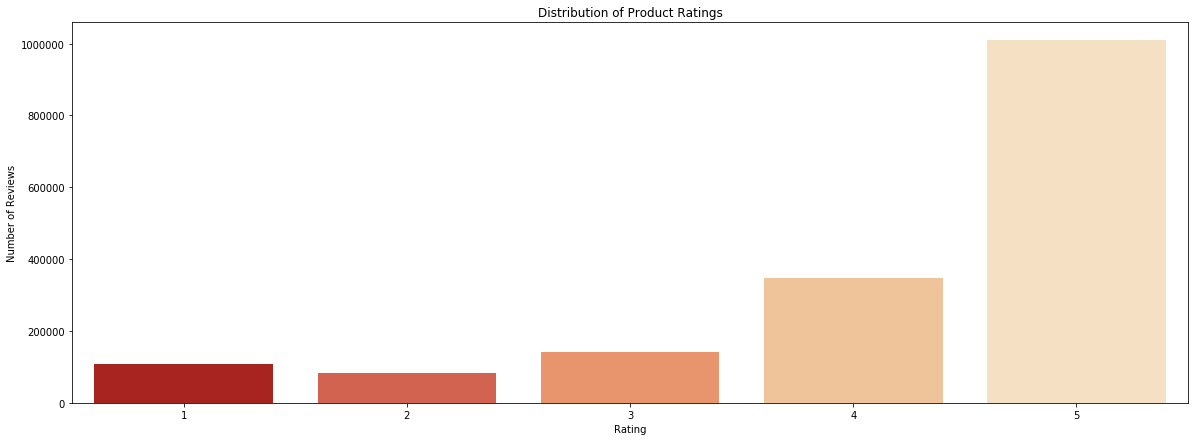

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

f, axes = plt.subplots(figsize=(20,7))
ax = sns.countplot(x=df["overall"], palette="OrRd_r")
ax.set(title="Distribution of Product Ratings", \
       xlabel="Rating", ylabel="Number of Reviews")
plt.show()

If the model simply classified every review as `5`, then the model would achieve an accuracy of around 60% given the entire dataset. Since this will still outperform predictions made by chance, we would therefore ensure that our test set is as stratified as the "balanced" training set.

In [9]:
majority = df["overall"] == 5
majority_ratio = len(df[majority]) / len(df)

print(f"{majority_ratio*100:.2f}%")

59.73%


## NLP Pre-Processing ##
We'll work with `reviewText` to prepare our model's final dataframe. The goal is to produce tokens for every document (i.e. every review). These documents will make up our corpora where we'll draw our vocabulary from.

The following is a sample text in its original form. This is the same as what was inspected in the previous section.

In [10]:
sample_review = df["reviewText"].iloc[1689185]
print(sample_review)

I&#8217;m a big fan of the Brainwavz S1 (actually all of their headphones &#8211; have yet to be disappointed with any of their products). The S1 has been my main set for active use (e.g., workouts, runs, etc.) since the flat cable is very durable and resistant to tangles. The S5 keeps all the good features of the S1 and adds to it &#8211; the sound quality is richer and better defined.That&#8217;s not to say the S1 sounds poor &#8211; they are quite good, in fact. But the S5 are better. The highs are better defined and the midrange has more punch to it. The bass comes through clearly without moving into the harsh territory when the volume is pushed (as the S1s can do). The overall sound quality is very pleasing.The build quality seems solid &#8211; as solid as the S1 or better. I love the flat cable! I know that&#8217;s something that is not appreciated by everyone, but for me it&#8217;s been working out wonderfully. Although this (as most other Brainwavz headsets) comes with an excel

### HTML Entities ###
Some special characters like the apostrophe (’) and the en dash (–) are expressed as a set of numbers prefixed by `&#` and suffixed by `;`. This is because the dataset was scraped from an HTML parser, and the dataset itself includes data that predated the universal UTF-8 standard.

These *HTML Entities* can be decoded by importing the `html` library.

In [11]:
import html

decoded_review = html.unescape(sample_review)
print(decoded_review)

I’m a big fan of the Brainwavz S1 (actually all of their headphones – have yet to be disappointed with any of their products). The S1 has been my main set for active use (e.g., workouts, runs, etc.) since the flat cable is very durable and resistant to tangles. The S5 keeps all the good features of the S1 and adds to it – the sound quality is richer and better defined.That’s not to say the S1 sounds poor – they are quite good, in fact. But the S5 are better. The highs are better defined and the midrange has more punch to it. The bass comes through clearly without moving into the harsh territory when the volume is pushed (as the S1s can do). The overall sound quality is very pleasing.The build quality seems solid – as solid as the S1 or better. I love the flat cable! I know that’s something that is not appreciated by everyone, but for me it’s been working out wonderfully. Although this (as most other Brainwavz headsets) comes with an excellent hard shell case, I usually tote my earbuds 

Since punctuation marks do not add value in the way we'll perform NLP, all the HTML entities in the review texts can be dropped. The output series `preprocessed` is our `reviewText` but without the special characters.

In [12]:
pattern = r"\&\#[0-9]+\;"

df["preprocessed"] = df["reviewText"].str.replace(pat=pattern, repl="", regex=True)

print(df["preprocessed"].iloc[1689185])

Im a big fan of the Brainwavz S1 (actually all of their headphones  have yet to be disappointed with any of their products). The S1 has been my main set for active use (e.g., workouts, runs, etc.) since the flat cable is very durable and resistant to tangles. The S5 keeps all the good features of the S1 and adds to it  the sound quality is richer and better defined.Thats not to say the S1 sounds poor  they are quite good, in fact. But the S5 are better. The highs are better defined and the midrange has more punch to it. The bass comes through clearly without moving into the harsh territory when the volume is pushed (as the S1s can do). The overall sound quality is very pleasing.The build quality seems solid  as solid as the S1 or better. I love the flat cable! I know thats something that is not appreciated by everyone, but for me its been working out wonderfully. Although this (as most other Brainwavz headsets) comes with an excellent hard shell case, I usually tote my earbuds wrapped 

### Extracting the root word ###
How often a word is used is key information in natural language processing. It is therefore important to reduce words to their root form. An example would be the usage of the word "*learn*". If we differentiate this base form from a modified version like "*learning*" then we might lose relational context between two documents that have used either word.

We'll be using Lemmatization to reduce tokens to their base word. This technique takes into account context similarity according to part-of-speech anatomy. Stemming is another common approach, although stemming only performs truncation and would not be able to reduce "*taught*" to "*teach*".

We will be using the *WordNetLemmatizer* from the Natural Language Toolkit (or *NLTK*). Lemmatization only applies to each word but it is dependent on sentence structure to understand context. We therefore need to have part-of-speech tags associated with each word. Our output is derived from applying the `lemmatize_doc` function to our `preprocessed` column.

The `lemmatize_doc` works as follows:
* Each review is broken down into a list of sentences
* Punctuations that only group words or separate sentences (hyphens therefore are excluded) are removed (replaced by whitespace) using RegEx
* Every sentence is further broken down into words (tokens)

Each of the sentences then becomes an ordered bag of words. Every word is then *tagged* to a part-of-speech. This word-tag tuple pair is then fed one at a time to the `lemmatize_word` function, which works as follows:
* Only modifiable words – nouns, verbs, adjectives, and adverbs – can be reduced to roots
* These words are lemmatized and appended to the `root` list
* Words that are not modifiable are added as they are to the `root` list

The output lists are linked together as a string using whitespace. In the end, each `preprocessed` review will retain its text form but with each word simplified as much as possible.

In [13]:
%%time
import re
import nltk

from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk.corpus import wordnet

#import nltk resources
resources = ["wordnet", "stopwords", "punkt", \
             "averaged_perceptron_tagger", "maxent_treebank_pos_tagger"]

#placeholder
#for resource in resources:
#    try:
#        nltk.data.find("tokenizers/" + resource)
#    except LookupError:
#        nltk.download(resource)

#create Lemmatizer object
lemma = WordNetLemmatizer()

def lemmatize_word(tagged_token):
    """ Returns lemmatized word given its tag"""
    root = []
    for token in tagged_token:
        tag = token[1][0]
        word = token[0]
        if tag.startswith('J'):
            root.append(lemma.lemmatize(word, wordnet.ADJ))
        elif tag.startswith('V'):
            root.append(lemma.lemmatize(word, wordnet.VERB))
        elif tag.startswith('N'):
            root.append(lemma.lemmatize(word, wordnet.NOUN))
        elif tag.startswith('R'):
            root.append(lemma.lemmatize(word, wordnet.ADV))
        else:          
            root.append(word)
    return root

def lemmatize_doc(document):
    """ Tags words then returns sentence with lemmatized words"""
    lemmatized_list = []
    tokenized_sent = sent_tokenize(document)
    for sentence in tokenized_sent:
        no_punctuation = re.sub(r"[`'\",.!?()]", " ", sentence)
        tokenized_word = word_tokenize(no_punctuation)
        tagged_token = pos_tag(tokenized_word)
        lemmatized = lemmatize_word(tagged_token)
        lemmatized_list.extend(lemmatized)
    return " ".join(lemmatized_list)

#apply our functions
df["preprocessed"] = df["preprocessed"].apply(lambda row: lemmatize_doc(row))

print(df["preprocessed"].iloc[1689185])

Im a big fan of the Brainwavz S1 actually all of their headphone have yet to be disappoint with any of their product The S1 have be my main set for active use e g workouts run etc since the flat cable be very durable and resistant to tangle The S5 keep all the good feature of the S1 and add to it the sound quality be rich and well define Thats not to say the S1 sound poor they be quite good in fact But the S5 be well The high be well define and the midrange have more punch to it The bass come through clearly without move into the harsh territory when the volume be push as the S1s can do The overall sound quality be very please The build quality seem solid as solid as the S1 or good I love the flat cable I know thats something that be not appreciate by everyone but for me its be work out wonderfully Although this as most other Brainwavz headset come with an excellent hard shell case I usually tote my earbuds wrap around my mp3 player in my pocket Easy to carry ; very stressful on the ca

### Removing Accents ###
Each review is normalized from longform UTF-8 to ASCII encoding. This will remove accents in characters and ensure that words like "*naïve*" will simply be interpreted as (and therefore not differentiated from) "*naive*".

In [14]:
from unicodedata import normalize

remove_accent = lambda text: normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore")

df["preprocessed"] = df["preprocessed"].apply(remove_accent)

print(df["preprocessed"].iloc[1689185])

Im a big fan of the Brainwavz S1 actually all of their headphone have yet to be disappoint with any of their product The S1 have be my main set for active use e g workouts run etc since the flat cable be very durable and resistant to tangle The S5 keep all the good feature of the S1 and add to it the sound quality be rich and well define Thats not to say the S1 sound poor they be quite good in fact But the S5 be well The high be well define and the midrange have more punch to it The bass come through clearly without move into the harsh territory when the volume be push as the S1s can do The overall sound quality be very please The build quality seem solid as solid as the S1 or good I love the flat cable I know thats something that be not appreciate by everyone but for me its be work out wonderfully Although this as most other Brainwavz headset come with an excellent hard shell case I usually tote my earbuds wrap around my mp3 player in my pocket Easy to carry ; very stressful on the ca

### Removing Punctuations ###
The `preprocessed` reviews are further cleaned by dropping punctuations. Using regular expressions, only whitespaces and alphanumeric characters are kept.

In [15]:
pattern = r"[^\w\s]"

df["preprocessed"] = df["preprocessed"].str.replace(pat=pattern, repl=" ", regex=True)

print(df["preprocessed"].iloc[1689185])

Im a big fan of the Brainwavz S1 actually all of their headphone have yet to be disappoint with any of their product The S1 have be my main set for active use e g workouts run etc since the flat cable be very durable and resistant to tangle The S5 keep all the good feature of the S1 and add to it the sound quality be rich and well define Thats not to say the S1 sound poor they be quite good in fact But the S5 be well The high be well define and the midrange have more punch to it The bass come through clearly without move into the harsh territory when the volume be push as the S1s can do The overall sound quality be very please The build quality seem solid as solid as the S1 or good I love the flat cable I know thats something that be not appreciate by everyone but for me its be work out wonderfully Although this as most other Brainwavz headset come with an excellent hard shell case I usually tote my earbuds wrap around my mp3 player in my pocket Easy to carry   very stressful on the ca

### Converting to Lower Case ###
Every letter is also converted to lower case. This makes it so that "*iPhone*" will not be distinguishable from "*iphone*".

In [16]:
df["preprocessed"] = df["preprocessed"].str.lower()

print(df["preprocessed"].iloc[1689185])

im a big fan of the brainwavz s1 actually all of their headphone have yet to be disappoint with any of their product the s1 have be my main set for active use e g workouts run etc since the flat cable be very durable and resistant to tangle the s5 keep all the good feature of the s1 and add to it the sound quality be rich and well define thats not to say the s1 sound poor they be quite good in fact but the s5 be well the high be well define and the midrange have more punch to it the bass come through clearly without move into the harsh territory when the volume be push as the s1s can do the overall sound quality be very please the build quality seem solid as solid as the s1 or good i love the flat cable i know thats something that be not appreciate by everyone but for me its be work out wonderfully although this as most other brainwavz headset come with an excellent hard shell case i usually tote my earbuds wrap around my mp3 player in my pocket easy to carry   very stressful on the ca

### Removing Stop Words ###
Stop words consist of the most commonly used words that include pronouns (e.g. *us*, *she*, *their*), articles (e.g. *the*), and prepositions (e.g. *under*, *from*, *off*). These words are not helpful in distinguishing a document from another and are therefore dropped.

Note that the `stop_words` were stripped of punctuations just as what we have done to our dataset.

In [17]:
from nltk.corpus import stopwords

stop_words = stopwords.words("english")

stop_words = [word.replace("\'", "") for word in stop_words]

print(f"sample stop words: {stop_words[:15]} \n")

remove_stop_words = lambda row: " ".join([token for token in row.split(" ") \
                                          if token not in stop_words])
df["preprocessed"] = df["preprocessed"].apply(remove_stop_words)

print(df["preprocessed"].iloc[1689185])

sample stop words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'youre', 'youve', 'youll', 'youd', 'your', 'yours'] 

im big fan brainwavz s1 actually headphone yet disappoint product s1 main set active use e g workouts run etc since flat cable durable resistant tangle s5 keep good feature s1 add sound quality rich well define thats say s1 sound poor quite good fact s5 well high well define midrange punch bass come clearly without move harsh territory volume push s1s overall sound quality please build quality seem solid solid s1 good love flat cable know thats something appreciate everyone work wonderfully although brainwavz headset come excellent hard shell case usually tote earbuds wrap around mp3 player pocket easy carry   stressful cable lead tangle round wire flat wire especially thick jacket survive abuse zero problem earbuds sleekly shape style s1 comfort line customary brainwavz style say outstanding come wide range tip fit pretty much ear plus comply fo

### Removing Extra Spaces ###
Again, we make use of regular expressions to ensure we never get more than a single whitespace to separate words in our sentences.

In [18]:
pattern = r"[\s]+"

df["preprocessed"] = df["preprocessed"].str.replace(pat=pattern, repl=" ", regex=True)

print(df["preprocessed"].iloc[1689185])

im big fan brainwavz s1 actually headphone yet disappoint product s1 main set active use e g workouts run etc since flat cable durable resistant tangle s5 keep good feature s1 add sound quality rich well define thats say s1 sound poor quite good fact s5 well high well define midrange punch bass come clearly without move harsh territory volume push s1s overall sound quality please build quality seem solid solid s1 good love flat cable know thats something appreciate everyone work wonderfully although brainwavz headset come excellent hard shell case usually tote earbuds wrap around mp3 player pocket easy carry stressful cable lead tangle round wire flat wire especially thick jacket survive abuse zero problem earbuds sleekly shape style s1 comfort line customary brainwavz style say outstanding come wide range tip fit pretty much ear plus comply foam tip favorite fit properly end zero ear irritation plus excellent sound isolation bass response ear design much like s1 never use design prior

## Tokenization ##
The entries for the `preprocessed` column are extracted to make up our *corpora*, which is simply a collection of all our documents. Each review is then transformed into an ordered list of words. This is the process of *tokenization* – the document is broken down into individual words or tokens.

Our tokenized sample review is below:

In [19]:
corpora = df["preprocessed"].values
tokenized = [corpus.split(" ") for corpus in corpora]

print(tokenized[1689185])

['im', 'big', 'fan', 'brainwavz', 's1', 'actually', 'headphone', 'yet', 'disappoint', 'product', 's1', 'main', 'set', 'active', 'use', 'e', 'g', 'workouts', 'run', 'etc', 'since', 'flat', 'cable', 'durable', 'resistant', 'tangle', 's5', 'keep', 'good', 'feature', 's1', 'add', 'sound', 'quality', 'rich', 'well', 'define', 'thats', 'say', 's1', 'sound', 'poor', 'quite', 'good', 'fact', 's5', 'well', 'high', 'well', 'define', 'midrange', 'punch', 'bass', 'come', 'clearly', 'without', 'move', 'harsh', 'territory', 'volume', 'push', 's1s', 'overall', 'sound', 'quality', 'please', 'build', 'quality', 'seem', 'solid', 'solid', 's1', 'good', 'love', 'flat', 'cable', 'know', 'thats', 'something', 'appreciate', 'everyone', 'work', 'wonderfully', 'although', 'brainwavz', 'headset', 'come', 'excellent', 'hard', 'shell', 'case', 'usually', 'tote', 'earbuds', 'wrap', 'around', 'mp3', 'player', 'pocket', 'easy', 'carry', 'stressful', 'cable', 'lead', 'tangle', 'round', 'wire', 'flat', 'wire', 'especi

## Phrase Modeling ##
Since order of words matter in most NLP models, it is often helpful to group neighboring words that appear to convey one meaning as though they are a single word, like *smart TV*.

To be considered a *phrase*, the number of times that two words should appear next to each other is set to at least `300`. The *threshold* then takes that minimum and compares it to the total number of token instances in the corpora. The higher the threshold, the more often two words must appear adjacent to be grouped into a phrase.

In [ ]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser

bi_gram = Phrases(tokenized, min_count=300, threshold=50)

tri_gram = Phrases(bi_gram[tokenized], min_count=300, threshold=50)

### Unigrams ###
Unigrams are single pieces of tokens. The code below takes all the unique words from the entire corpora and prints a sample:

In [22]:
uni_gram_tokens = set([token for text in tokenized for token in text])
uni_gram_tokens = set(filter(lambda x: x != "", uni_gram_tokens))

print(list(uni_gram_tokens)[:50])

['childen', 'andpowered', 'whitestone', 'collapased', 'tastictwo', 'renamedtuff', 'protectable', 'preset', 'specificationssupported', 'editingmint', 'starsconsthe', 'froman', '829b', 'quikstrips', 'transfare', 'minohdbut', 'zonking', 'sqeegeeing', 'lc60i', 'arefinished', 'c6b', 'bouillon', 'wirelesscams', 'rf3f2gvw3jf0j', 'coversi', 'atseahorse', 'removed', 'spilitter', 'sooriginal', 'lightweightnice', 'heckcrucial', 'easilytl', 'rubberized', 'shootingfast', 'slimlines', 'purchasedringke', 'junk', 'nc8000', 'balcar', 'streetpilotat', '51color', 'connectsamson', '13box', 'nono', 'mytrusty', 'offdvd', 'dtmptool', 'burnable', 'ahhhclip', 'accessoriesstep']


### Bigrams ###
Bigrams are generated from using the *gensim* phraser. Only those that pass the `bi_gram` criteria are considered.

The code below takes all the unique bigram phrases from the entire corpora:

In [23]:
bigram_min = bi_gram.min_count

bi_condition = lambda x: x[1] >= bigram_min

bi_gram_tokens = dict(filter(bi_condition, bi_gram.vocab.items()))
bi_gram_tokens = set([token.decode("utf-8") \
                      for token in bi_gram_tokens])

bi_grams_only = bi_gram_tokens.difference(uni_gram_tokens)
print(list(bi_grams_only)[1:51]) ##placeholder

['hdmi_dvi', 'lens_without', 'time_forget', 'like_return', '2_00', 'fast_run', 'make_convenient', 'point_think', 'matter_fact', 'although_make', 'actually_see', 'sure_problem', 'course_good', 'get_catch', 'take_find', 'include_product', 'problem_design', 'work_everything', 'standard_camera', '1080p_120hz', 'make_give', 'set_ipad', 'control_cable', 'nikon_brand', 'really_beat', 'game_also', 'tiny_size', 'tiny_camera', 'use_default', 'color_come', 'get_12', 'plug_network', 'piece_technology', 'light_fit', 'button_click', '4kb_qd', 'wheel_click', 'wish_purchase', 'hold_device', 'ipod_phone', 'might_break', 'work_need', 'big_small', 'tell_would', 'lot_high', 'noise_ratio', 'less_200', 'star_seem', 'design_camera', 'camera_function']


### Trigrams ###
Trigrams are generated by applying another *gensim* phraser on top of a bigram phraser. Take for example the tokens *sd* and *card*. Because they appear often together enough, they become linked together as *sd_card*. In turn, if *sd_card* appears adjacent to the token *reader* in enough instances, then the `tri_gram` model would link them together as well to tokenize *sd_card_reader*.

The code below takes all the unique trigram phrases from the entire corpora:

In [24]:
trigram_min = tri_gram.min_count

tri_condition = lambda x: x[1] >= trigram_min

tri_gram_tokens = dict(filter(tri_condition, tri_gram.vocab.items()))
tri_gram_tokens = set([token.decode("utf-8") \
                       for token in tri_gram_tokens])

tri_grams_only = tri_gram_tokens.difference(bi_gram_tokens)
print(list(tri_grams_only)[:50])

['play_blu_ray', 'samsung_galaxy_s4', 'old_macbook_pro', 'quality_top_notch', 'b_w_filter', 'one_living_room', 'mac_os_x', 'far_exceed_expectation', 'nexus_7_2013', 'cell_phone_use', 'customer_service_great', '5d_mark_iii', 'cell_phone_camera', 'macbook_pro_work', 'first_blu_ray', 'case_nexus_7', 'double_sided_tape', 'price_highly_recommended', 'almost_non_existent', '2_4ghz_5ghz', 'macbook_pro_13', 'customer_service_rep', 'samsung_840_pro', 'blu_ray_disk', 'use_third_party', 'n_uuml_vi', 'home_theater_pc', 'complete_waste_money', 'small_form_factor', 'use_home_theater', 'fast_forward_rewind', 'wi_fi_connection', 'amazon_return_policy', 'new_kindle_fire', '192_168_1', 'aps_c_sensor', 'ear_bud_come', 'mp3_player_work', 'mp3_player_use', 'use_macbook_pro', 'run_os_x', 'canon_5d_mark', 'blu_ray_movie', 'western_digital_passport', 'dd_wrt_firmware', 'inch_macbook_pro', 'heart_rate_monitor', 'great_mp3_player', 'kindle_fire_hd', 'samsung_galaxy_tab']


The `tri_gram` and `bi_gram` phrasers are applied to our `tokenized` corpora.

In [25]:
#tokenized = [Phraser(tri_gram)[Phraser(bi_gram)[i]] for i in tokenized] ##placeholder

Single-character tokens are removed from every tokenized document. Our tokenized review, in its final form, is below.

In [26]:
tokenized = [list(filter(lambda x: len(x) > 1, document)) \
             for document in tokenized]

print(tokenized[1689185])

['im', 'big', 'fan', 'brainwavz', 's1', 'actually', 'headphone', 'yet', 'disappoint', 'product', 's1', 'main', 'set', 'active', 'use', 'workouts', 'run', 'etc', 'since', 'flat', 'cable', 'durable', 'resistant', 'tangle', 's5', 'keep', 'good', 'feature', 's1', 'add', 'sound', 'quality', 'rich', 'well', 'define', 'thats', 'say', 's1', 'sound', 'poor', 'quite', 'good', 'fact', 's5', 'well', 'high', 'well', 'define', 'midrange', 'punch', 'bass', 'come', 'clearly', 'without', 'move', 'harsh', 'territory', 'volume', 'push', 's1s', 'overall', 'sound', 'quality', 'please', 'build', 'quality', 'seem', 'solid', 'solid', 's1', 'good', 'love', 'flat', 'cable', 'know', 'thats', 'something', 'appreciate', 'everyone', 'work', 'wonderfully', 'although', 'brainwavz', 'headset', 'come', 'excellent', 'hard', 'shell', 'case', 'usually', 'tote', 'earbuds', 'wrap', 'around', 'mp3', 'player', 'pocket', 'easy', 'carry', 'stressful', 'cable', 'lead', 'tangle', 'round', 'wire', 'flat', 'wire', 'especially', 'th

## Creating the Vocabulary ##
The `vocabulary` is the key-value pairs of all the unique tokens from every product review. Each token is assigned a lookup ID. The first 10 words in our dictionary are as follows:

In [27]:
from gensim.corpora.dictionary import Dictionary

vocabulary = Dictionary(tokenized)

vocabulary_keys = list(vocabulary.token2id)[0:10]

for key in vocabulary_keys:
    print(f"ID: {vocabulary.token2id[key]}, Token: {key}")

ID: 0, Token: address
ID: 1, Token: around
ID: 2, Token: arrive
ID: 3, Token: back
ID: 4, Token: bad
ID: 5, Token: big
ID: 6, Token: come
ID: 7, Token: contact
ID: 8, Token: could
ID: 9, Token: day


## Count-based Feature Engineering ##
In order for a machine learning model to work with text input, the document must first be *vectorized*. This simply means that the input has to be converted into containers of numerical values.

### Bag of Words Model ###
The classical approach in expressing text as a set of features is getting the token frequency. Each entry to the dataframe is a document while each column corresponds to every unique token in the entire corpora. The row will identify how many times a word appears in the document. The `bow` model for the sample review is below:

In [28]:
bow = [vocabulary.doc2bow(doc) for doc in tokenized]

for idx, freq in bow[0]:
    print(f"Word: {vocabulary.get(idx)}, Frequency: {freq}")

Word: address, Frequency: 1
Word: around, Frequency: 1
Word: arrive, Frequency: 1
Word: back, Frequency: 1
Word: bad, Frequency: 1
Word: big, Frequency: 2
Word: come, Frequency: 1
Word: contact, Frequency: 1
Word: could, Frequency: 1
Word: day, Frequency: 1
Word: earlier, Frequency: 1
Word: ease, Frequency: 2
Word: ect, Frequency: 1
Word: email, Frequency: 2
Word: exception, Frequency: 1
Word: exchange, Frequency: 1
Word: expect, Frequency: 1
Word: freeze, Frequency: 2
Word: get, Frequency: 1
Word: glitch, Frequency: 1
Word: gps, Frequency: 1
Word: great, Frequency: 2
Word: however, Frequency: 1
Word: husband, Frequency: 1
Word: impressed, Frequency: 2
Word: instruction, Frequency: 1
Word: love, Frequency: 1
Word: luck, Frequency: 1
Word: memory, Frequency: 1
Word: million, Frequency: 1
Word: minute, Frequency: 1
Word: normal, Frequency: 1
Word: nothing, Frequency: 1
Word: one, Frequency: 1
Word: option, Frequency: 1
Word: otr, Frequency: 1
Word: person, Frequency: 1
Word: probably, Fr

### TF-IDF Model ###
The Term Frequency-Inverse Document Frequency (*TF-IDF*) approach assigns continuous values instead of simple integers for the token frequency. Words that appear frequently overall tend to not establish saliency in a document, and are thus weighted lower. Words that are unique to some documents tend to help distinguish it from the rest and are thus weighted higher. The `tfidf` weighting is based on our `bow` variable.

In [29]:
from gensim.models.tfidfmodel import TfidfModel

tfidf = TfidfModel(bow)

for idx, weight in tfidf[bow[0]]:
    print(f"Word: {vocabulary.get(idx)}, Weight: {weight:.3f}")

Word: address, Weight: 0.113
Word: around, Weight: 0.060
Word: arrive, Weight: 0.093
Word: back, Weight: 0.051
Word: bad, Weight: 0.068
Word: big, Weight: 0.126
Word: come, Weight: 0.046
Word: contact, Weight: 0.103
Word: could, Weight: 0.054
Word: day, Weight: 0.061
Word: earlier, Weight: 0.141
Word: ease, Weight: 0.220
Word: ect, Weight: 0.181
Word: email, Weight: 0.213
Word: exception, Weight: 0.131
Word: exchange, Weight: 0.132
Word: expect, Weight: 0.067
Word: freeze, Weight: 0.259
Word: get, Weight: 0.028
Word: glitch, Weight: 0.141
Word: gps, Weight: 0.102
Word: great, Weight: 0.059
Word: however, Weight: 0.064
Word: husband, Weight: 0.126
Word: impressed, Weight: 0.211
Word: instruction, Weight: 0.090
Word: love, Weight: 0.057
Word: luck, Weight: 0.114
Word: memory, Weight: 0.084
Word: million, Weight: 0.158
Word: minute, Weight: 0.079
Word: normal, Weight: 0.099
Word: nothing, Weight: 0.080
Word: one, Weight: 0.028
Word: option, Weight: 0.080
Word: otr, Weight: 0.264
Word: per

## Word Embedding for Feature Engineering ##
The downside of count-based techniques is that without regards to word sequence and sentence structure, the semantics get lost. The *Word2Vec* technique, on the other hand, actually embeds meaning in vectors by quantifying how often a word appears within the vicinity of a given set of other words.

A context window the span of `context_size` slides across every document one token at a time. In each step, the center word is described by its adjacent words and the probability that the token appears together with the others is expressed in `feature_size` dimensions. Since the minimum word requirement is set to `1`, every token in the corpora is embedded in the *Word2Vec* model.

In [30]:
%%time
import numpy as np

from gensim.models import word2vec

np.set_printoptions(suppress=True)

feature_size = 100
context_size = 20
min_word = 1

word_vec= word2vec.Word2Vec(tokenized, size=feature_size, \
                            window=context_size, min_count=min_word, \
                            iter=50, seed=42)

Wall time: 1h 33min 7s


## Final Dataframe ##
The goal is to have a dataframe with observations corresponding to the product reviews. In a given review, the `word_vec` model is applied to every word thus creating the `vector_array`. Its shape, therefore, is the word count on *axis 0* and the number of dimensions on *axis 1*. The mean of the `vector_array` is taken along *axis 0* for every document. This singularizes multiple word embeddings into one observation for each review.

The `mean_vectors` only initiates the array to give it its shape and is dropped when `model_df` is created. Every document is provided the ground truth label by imposing its `overall` rating. This completes our finalized `model_df` dataframe.

In [ ]:
%%time
mean_vectors = np.zeros(feature_size)

for document in tokenized:
    if np.shape(document) != (0, ):
        vector_list = [word_vec[word] for word in document] 
        vector_array = np.array(vector_list)
        vector_array = [np.mean(vector_array[:,i]) \
                        for i in range(feature_size)]
    else:
        vector_array = np.zeros(100)
    mean_vectors = np.vstack((mean_vectors, vector_array))
    
model_df = pd.DataFrame(mean_vectors[1:])
model_df["label"] = df["overall"]

display(model_df.head())

#placeholder
import pickle
f = open("df.pckl", "wb")
pickle.dump(model_df, f)
f.close()

# Exploratory Data Analysis #
We'll implement several interesting Natural Language Processing techniques in order to explore our Amazon dataset.

## Principal Component Analysis ##
We use Principal Component Analysis (*PCA*) on our `model_df` to reduce its 100 dimensions to just two dimensions. This will help visualize if there is a clear decision boundary along the five `overall` rating classifications. The more datapoints belonging to the same class are clustered together, the higher the likelihood that our machine learning model is simpler and more effective.

In [ ]:
%%time
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
pca = pca.fit_transform(model_df[:-1])
labels = model_df["label"]

f, axes = plt.subplots(figsize=(20,7))

for i in range(len(labels)):
    label = labels[i]
    x, y = pca[i-1]
    color_map = {1:"blue", 2:"red", 3:"yellow", 4:"green", 5:"orange"}
    color = color_map[label]
    plt.scatter(x, y, c=color)

## More on Word2Vec ##
To better appreciate the concept of word embeddings, we take five common words in our corpora and derive their five most related words using our `word_vec` model. The similarity comes from how often these tokens appear in the same window of words as their `word_bank` counterpart.

In [33]:
word_bank = ["nook", "phone", "tv", "good", "price"]

for word in word_bank[:]:
    related_vec = word_vec.wv.most_similar(word, topn=5)
    related_words = np.array(related_vec)[:,0]
    word_bank.extend(related_words)
    print(f"{word}: {related_words}")

nook: ['kindle' 'ereader' 'nookcolor' 'kobo' 'paperwhite']
phone: ['cellphone' 'smartphone' 'cell' 'droid' 'iphone']
tv: ['television' 'hdtv' 'tvs' 'vizio' 'flatscreen']
good: ['decent' 'great' 'wise' 'excellent' 'descent']
price: ['pricing' 'cost' 'priced' 'pricetag' 'expensive']


### t-SNE ###
Like PCA, the t-Distributed Stochastic Neighbor Embedding (*t-SNE*) is another dimensionality reduction technique to assist in visualizing high-dimensional datasets. To perceive the similarity between the related words in terms of spacial distance, t-SNE provided the coordinates of each word in a 2D scatterplot plane.

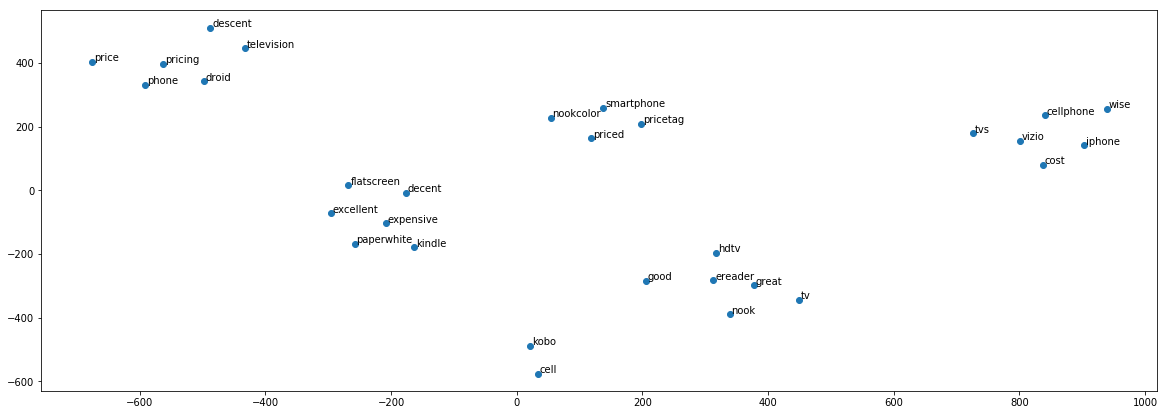

In [34]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=5, n_iter=1000, random_state=42)

sample_vecs = word_vec.wv[set(word_bank)]
sample_tsne = tsne.fit_transform(sample_vecs)
tsne_x = sample_tsne[:, 0]
tsne_y = sample_tsne[:, 1]

f, axes = plt.subplots(figsize=(20,7))
ax = plt.scatter(x=tsne_x, y=tsne_y)

for label, x, y in zip(word_bank, tsne_x, tsne_y):
    plt.annotate(label, xy=(x+3, y+3))

plt.show()

### Word Algebra ###
Since *Word2Vec* characterizes words into quantified tokens, we can consequently add or subtract word vectors together. To add is to combine the meaning of the components and to subtract is to take out the context of one token from another. The following are examples of this vector algebra:

**Books + Touchscreen**

In [41]:
word_vec.wv.most_similar(positive=["books", "touchscreen"], \
                      negative=[], topn=1)

[('ebooks', 0.6847387552261353)]

**Cheap – Quality**

In [36]:
word_vec.wv.most_similar(positive=["cheap"], \
                      negative=["quality"], topn=1)

[('ebay', 0.4894425570964813)]

**Tablet – Phone**

In [63]:
word_vec.wv.most_similar(positive=["tablet"], \
                      negative=["phone"], topn=1)

[('netbooks', 0.5097050666809082)]

## Named-Entity Recognition ###
We've seen *gensim* perform word tagging to identify part-of-speech. Now we use *spaCy* to go further and identify what nouns in the documents refer to. Some Named-Entity Recognition (*NER*) classification tags include distinguishing persons, organizations, products, places, dates, etc.

In exploring *spaCy*, we'll be using the `most_helpful_text`, which is the highest-rated product review by Amazon users. The `helpful` series from the `df` dataframe is actually a list with its first element storing the number of *helpful* votes a review received, and the second element containing the total number of *helpful* and *not helpful* review votes.

In [64]:
helpful = df["helpful"].tolist()
most_helpful = max(helpful, key=lambda x: x[0])

most_helpful_idx = df["helpful"].astype(str) == str(most_helpful)
most_helpful_idx = df[most_helpful_idx].index

most_helpful_text = df["reviewText"].iloc[most_helpful_idx].values[0]

print(most_helpful_text)

I've been an iPad user since the original came out. I also have an iPad 3. I have worked in IT for the past few years so I would say I am pretty good with technology and fancy new devices. With that introduction out of the way, I will be reviewing key points that I have seen touched upon in other reviews. Here goes...BUILDThe device feels nice and solid. I'm a little surprised at how heavy it is, but that's not necessarily a bad thing. The rubberized backing is always nice for added grip. It's not as nice as say unibody aluminum, but it's not $500 either.SCREENThe screen is fantastic. But my problem is the same as when iPad got Retina Display, other than the OS, most apps look rather pixelated. A lot of the games I tried are not high definition, at least not high enough to look smooth on this screen. Hopefully apps get updated to higher resolutions.LOCK SCREEN ADSYeah there are ads on my lock screen. I'm not sure why this is such a big deal. How much time do people really spend looking

We use `ner_dict`, a dictionary initialized as a list, to segregate the nouns in the `most_helpful_text` into the NER tags.

In [65]:
%%time
import spacy

from collections import defaultdict

ner = spacy.load("en")

ner_helpful = ner(most_helpful_text)

ner_dict = defaultdict(list)
for entity in ner_helpful.ents:
    ner_dict[entity.label_].append(entity)

for NER, name in ner_dict.items():
    print(f"{NER}:\n{name}\n")

ORG:
[iPad, iPad, OS, LOCK SCREEN, Amazon, OS, Amazon, iPad, iPad, Amazon, iPad, iPad, Power/Volume Buttons, iPad, Seek & Find, Amazon, iPad, MUSICI, Samsung Galaxy S3, iSyncr, Amazon, Amazon Customer Service, Amazon, Amazon, Apple, Amazon, Amazon, HDMI CONNECTIONI, HDMI, Samsung, Amazon, OS, OS, LEFT HAND MODEI, Avia Media Player, GOOGLE, Google]

DATE:
[the past few years, the past 24, 9/20/12Two days later, an appointment days later, this past weekend]

MONEY:
[500, 200, 15, another $200+, 200.UPDATE, 3]

PERSON:
[Retina Display, Netflix, to.-, Screen Glare, Cloud Player, Battery HD, DID, Home, APPI]

ORDINAL:
[first]

CARDINAL:
[two, 46, two, 5, 4]

GPE:
[Caltrain, Palo Alto, iTunes, Cloud, Cloud, Kindle, Kindle, Bluray, Kindle, mp4, 11/15/12Still, Solitaire, LA, SF, Kindle]

NORP:
[Enigmatis]

TIME:
[about an hour and a half, 5 minute]

PERCENT:
[about 15 - 20%, 100%]

WORK_OF_ART:
[Easy Phone Transfer]

FAC:
[Kindle]

LOC:
[Kindle, Kindle Support, Kindle]

PRODUCT:
[Google Play]


We use `displaCy` to visualize the tags in the review.

In [66]:
from spacy import displacy

displacy.render(ner_helpful, style="ent", jupyter=True)

## Dependency Tree ##
The capability of *spaCy'*s NER is based on deciphering the structure of the sentence by breaking down how tokens interact with and influence each other. Below is the dependency trees of the first two sentences of the `most_helpful_text`.

In [67]:
def ner_displacy(sentence):
    ner_sentence = ner(sentence)
    displacy.render(ner_sentence, jupyter=True, \
                    options={"compact": False, \
                             "distance": 90, \
                             "word_spacing":20, \
                             "arrow_spacing":10, \
                             "arrow_stroke": 2, \
                             "arrow_width": 5})

for sentence in most_helpful_text.split(".")[0:3]:
    ner_displacy(sentence)

## Topic Modeling ##


Because Latent Dirichlet Allocation (*LDA*) can cluster documents together according to topic, the reviews can be classified and grouped according to the type of electronics product they correspond to. The product reviews will have weights assigned to each of the topic, and the topics themselves will have weights on every token. As it is a clustering-based model, LDA is unsupervised and only the `num_topics` is configurable.

The following are the top five words that are salient to the first group of product reviews.

In [70]:
%%time
import multiprocessing

from gensim.models.ldamulticore import LdaMulticore

cores = multiprocessing.cpu_count()

num_topics = 10
bow_lda = LdaMulticore(bow, num_topics=num_topics, id2word=vocabulary, \
                       passes=5, workers=cores, random_state=42)

for token, frequency in bow_lda.show_topic(0, topn=5):
    print(token, frequency)

get 0.011734774
work 0.011198829
use 0.0095958505
router 0.009158912
device 0.008855804
Wall time: 1h 6min 17s


The words that are the most characteristic of the topics are indeed thematic. And each word group do conjure a distinct topic.

In [75]:
for topic in range(0, num_topics):
    print(f"Topic {topic+1}:")
    for token, frequency in bow_lda.show_topic(topic, topn=5):
        print(f" {token}, {frequency}")

Topic 1:
 get, 0.011734774336218834
 work, 0.011198828928172588
 use, 0.009595850482583046
 router, 0.009158912114799023
 device, 0.008855803869664669
Topic 2:
 sound, 0.034996841102838516
 speaker, 0.0209796279668808
 good, 0.015011309646070004
 headphone, 0.013791842386126518
 quality, 0.011160140857100487
Topic 3:
 lens, 0.03160819783806801
 bag, 0.018301470205187798
 camera, 0.014126963913440704
 use, 0.01146912481635809
 strap, 0.008649271912872791
Topic 4:
 cable, 0.031109070405364037
 work, 0.02897009812295437
 usb, 0.025115681812167168
 drive, 0.023603621870279312
 great, 0.017832685261964798
Topic 5:
 case, 0.03297600895166397
 cover, 0.012749520130455494
 screen, 0.011409485712647438
 like, 0.011152341961860657
 ipad, 0.010687867179512978
Topic 6:
 battery, 0.02778122015297413
 charge, 0.025451648980379105
 use, 0.017372693866491318
 phone, 0.016959380358457565
 one, 0.01309022307395935
Topic 7:
 camera, 0.0475146621465683
 use, 0.01570322923362255
 picture, 0.012167769484221

Using *pyLDAvis*, we can interactively explore the words associated with the topics derived by LDA. The Intertopic Distance Map shows how some product reviews in one topic converge with others due to similarity. If needed, we can adjust the `num-topics` accordingly to cluster together topic intersections so a more evident decision boundary between classes can be established.

In [74]:
import pyLDAvis.gensim

lda_idm = pyLDAvis.gensim.prepare(bow_lda, bow, vocabulary)

pyLDAvis.display(lda_idm)

In [ ]:
#word cloud for visualization AFTER the model is trained and tuned